In [2]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [180]:
import copy
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Literal
import hashlib
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm


sns.set()


In [4]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)
    plt.savefig(name, **kwargs)


In [137]:
metric_cols = ["time_cpu", "restarts", "conflicts", "decisions", "propagations"]


def show_time_stats(
    data: pd.DataFrame,
    groupby: str = "instance",
    col: str = "time_cpu",
    title: str = "",
    range: tuple[float, float] | None = None,
):
    grouped = data.groupby(groupby)[col]
    std = grouped.std(ddof=1) / grouped.mean()
    p95 = np.percentile(std, 95)
    p99 = np.percentile(std, 99)
    if range is None:
        range = (0, p99)
    plt.hist(std, bins=20, range=range)
    plt.xlabel("Standard deviation (%)")
    plt.ylabel("Frequency")

    stats_text = (
        f"Mean std: {std.mean():.1%}\n"
        f"95-th percentile: {p95:.1%}\n"
        f"99-th percentile: {p99:.1%}\n"
        f"Max std: {std.max():.1%}"
    )
    plt.text(
        0.98,
        0.98,
        stats_text,
        transform=plt.gca().transAxes,
        ha="right",
        va="top",
        ma="left",
    )
    if title:
        plt.title(title)
    plt.tight_layout()


def show_corr(data: pd.DataFrame):
    metrics = data[metric_cols]

    corr = metrics.corr("kendall")
    corr_mask = np.triu(np.ones(len(corr)))
    sns.heatmap(
        corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask
    )
    plt.grid()


def hash_df(df: pd.DataFrame):
    h = hashlib.sha1()
    for col in df.columns:
        h.update(col.encode())
        h.update(b"\0")
    h.update(pd.util.hash_pandas_object(df).values)
    return h.hexdigest()


## Large instances

In [84]:
large = pd.read_csv("../instances/random_large/metrics.csv")
large.sort_values(["instance", "run"], inplace=True)

(large.groupby("instance").std().drop(["time_cpu", "run"], axis=1) == 0).all()


feasible        True
restarts        True
conflicts       True
decisions       True
propagations    True
dtype: bool

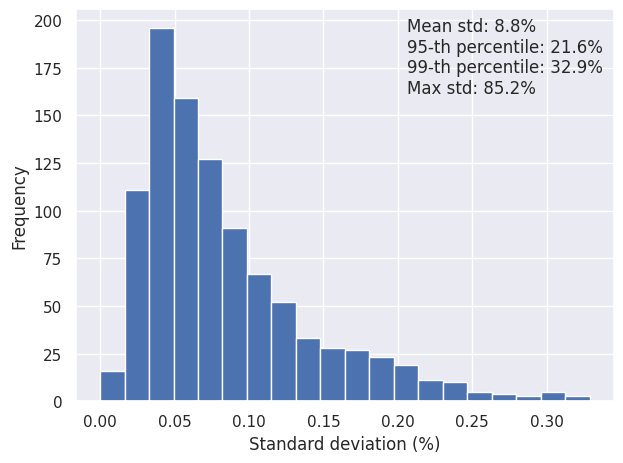

In [7]:
show_time_stats(large)


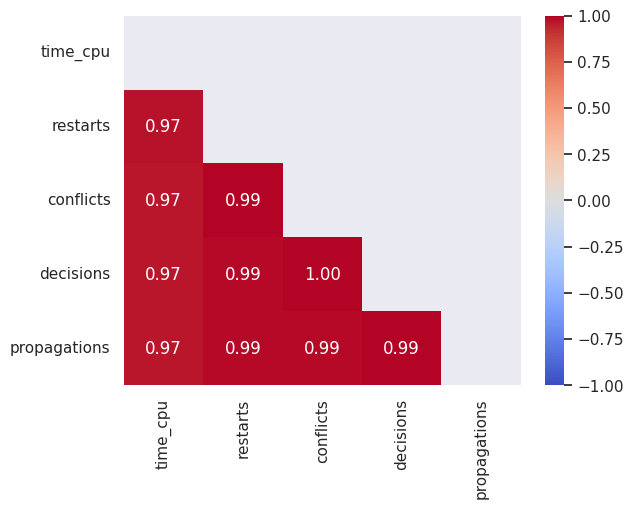

In [91]:
show_corr(large)
savefig("figs/metrics_large_corr.png")


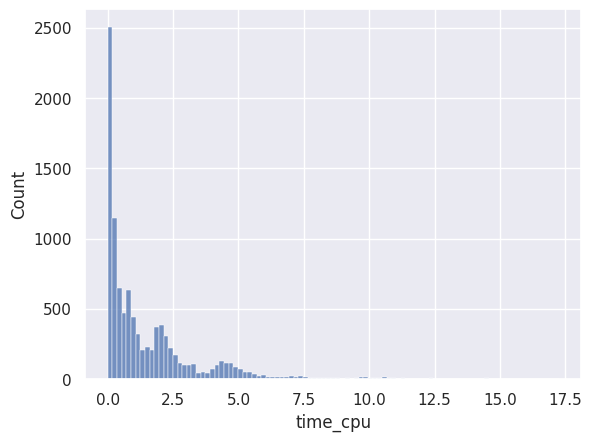

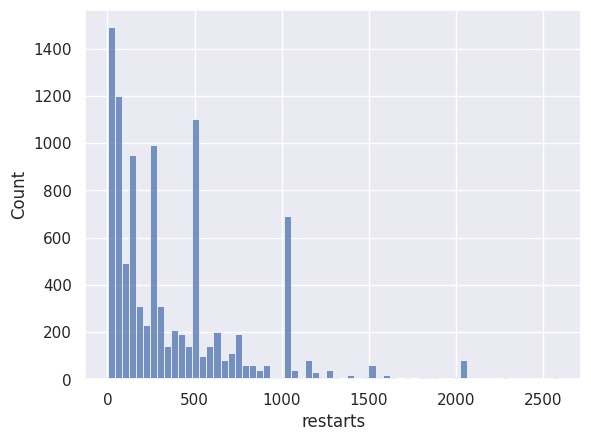

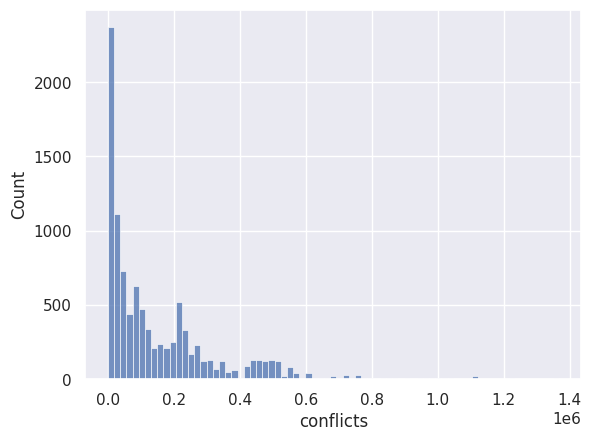

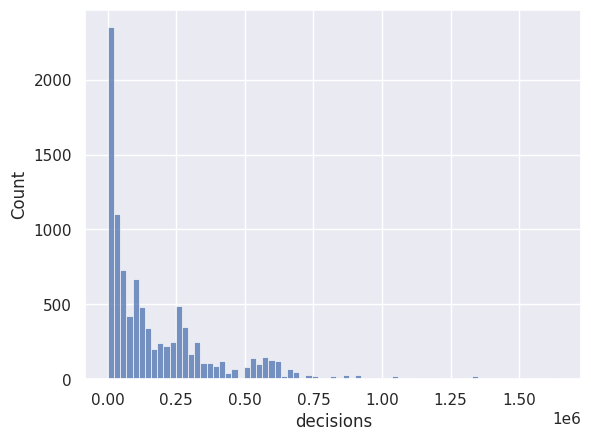

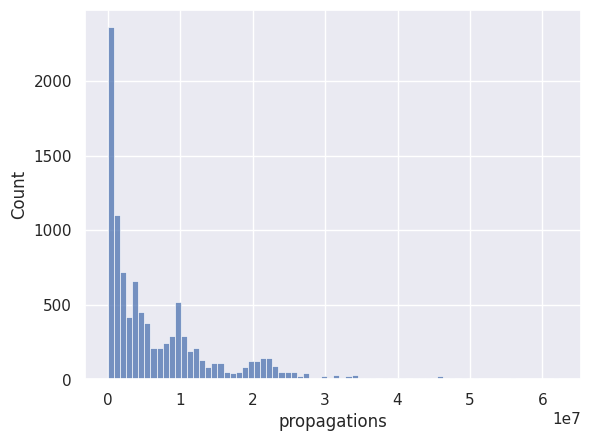

In [78]:
for col in metric_cols:
    sns.histplot(x=col, data=large)
    plt.show()


/home/fernando/.local/share/virtualenvs/hard_instances-tQ8GgIsG/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


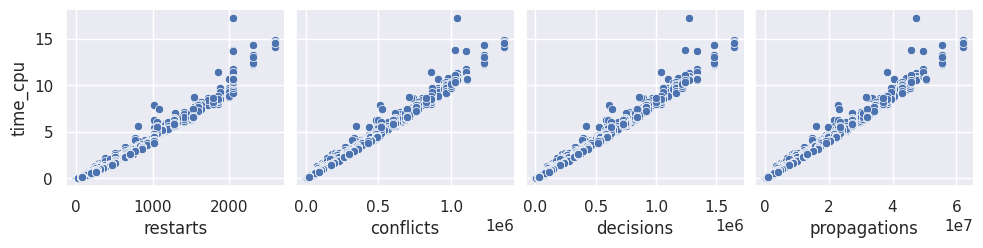

In [92]:
sns.pairplot(
    data=large,
    x_vars=["restarts", "conflicts", "decisions", "propagations"],
    y_vars="time_cpu",
)


## Small instances

In [193]:
small = pd.read_csv("../instances/random_small/metrics.csv")
(small.groupby("instance").std().drop(["time_cpu", "run"], axis=1) == 0).all()


feasible        True
restarts        True
conflicts       True
decisions       True
propagations    True
dtype: bool

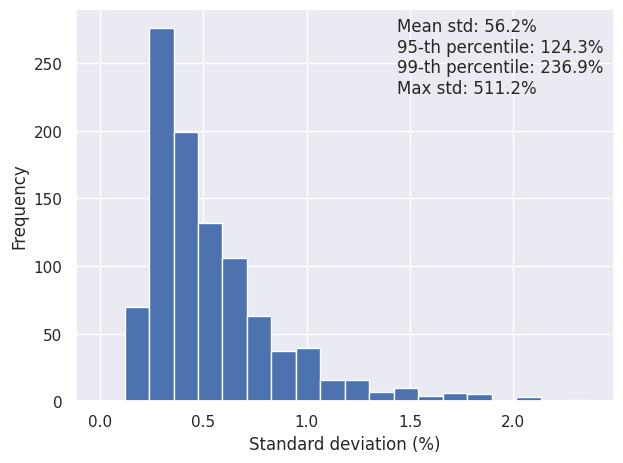

In [94]:
show_time_stats(small)


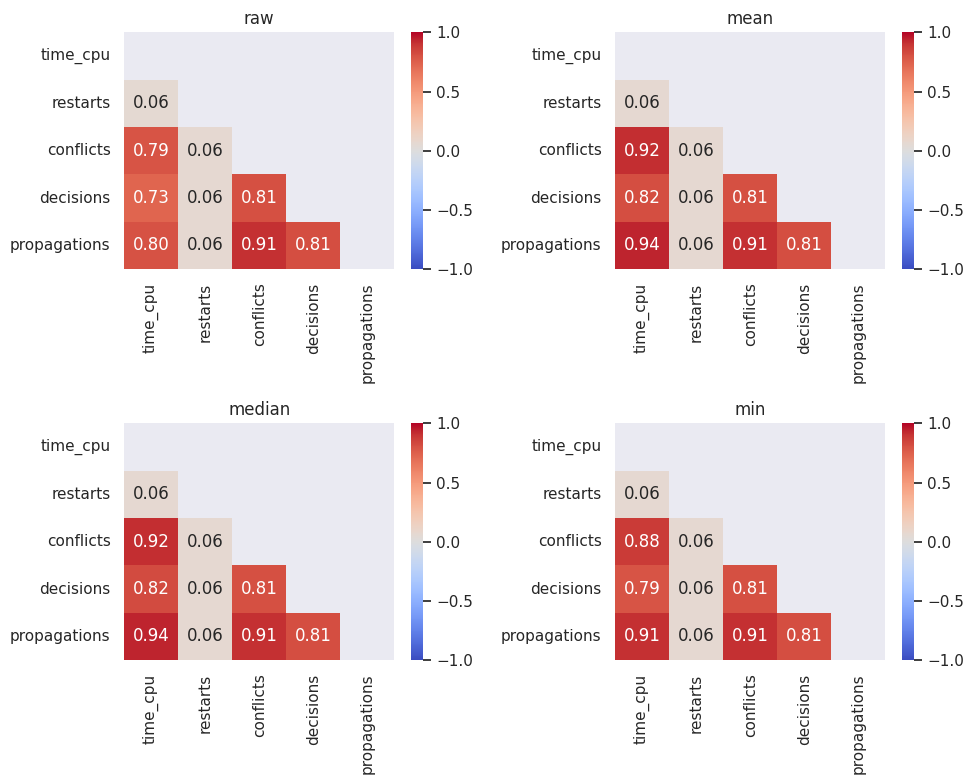

In [101]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.title("raw")
show_corr(small)

plt.subplot(222)
plt.title("mean")
show_corr(small.groupby("instance").mean())

plt.subplot(223)
plt.title("median")
show_corr(small.groupby("instance").median())

plt.subplot(224)
plt.title("min")
show_corr(small.groupby("instance").min())

plt.tight_layout()
savefig("figs/metrics_small_corr.png")


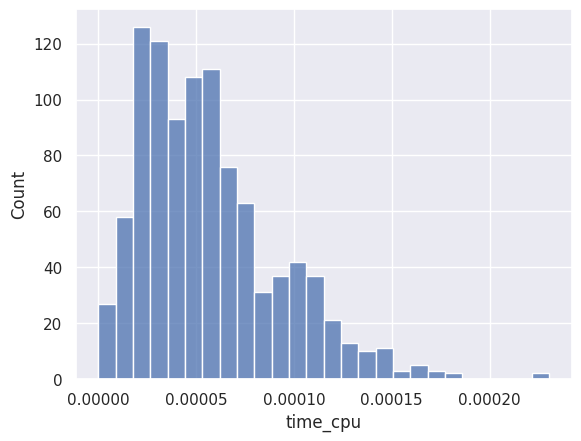

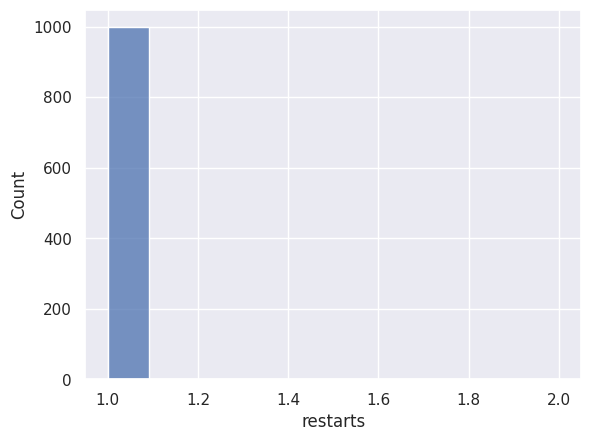

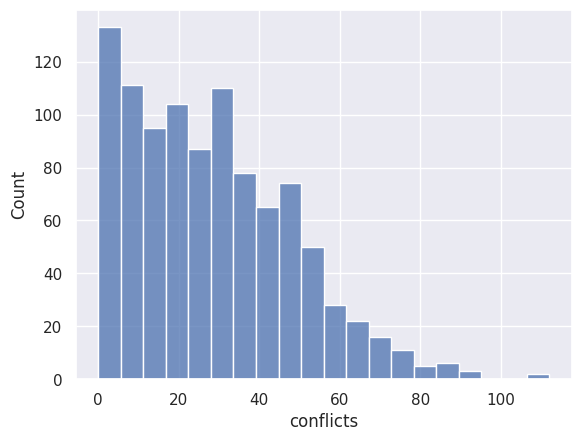

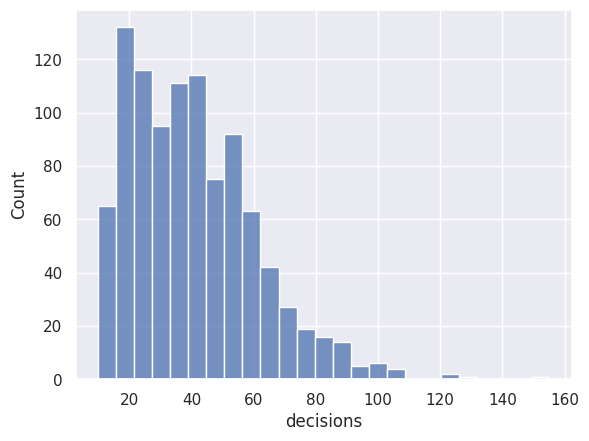

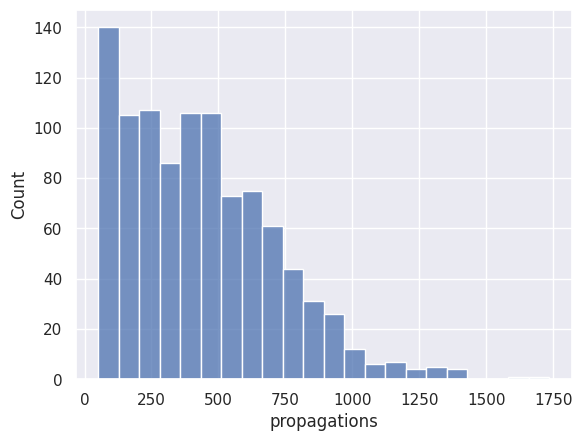

In [14]:
for col in metric_cols:
    sns.histplot(x=col, data=metrics_small)
    plt.show()


/home/fernando/.local/share/virtualenvs/hard_instances-tQ8GgIsG/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


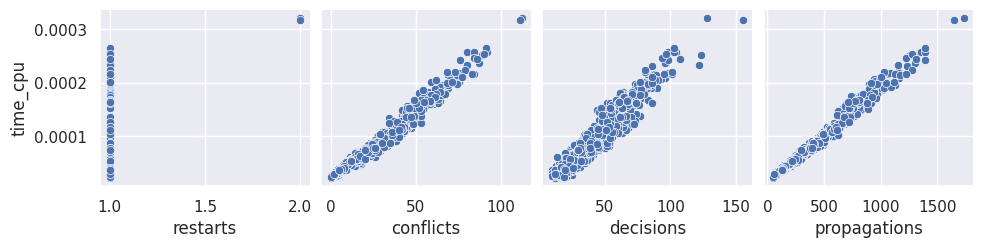

In [106]:
sns.pairplot(
    data=metrics_small,
    x_vars=["restarts", "conflicts", "decisions", "propagations"],
    y_vars="time_cpu",
)


### Averaging

In [195]:
def get_random_means(
    df: pd.DataFrame,
    group_size: int = 3,
    agg_fn: str = "mean",
    random_state: int = 42,
):
    resampled = df.sample(
        len(df) * group_size, replace=True, random_state=random_state
    ).reset_index(drop=True)
    means = resampled.rolling(group_size).agg(agg_fn)
    non_overlapping_means = means[group_size - 1 :: group_size]
    non_overlapping_means.reset_index(drop=True, inplace=True)
    non_overlapping_means.index.name = "run"
    return non_overlapping_means


def resample_and_average_times(
    df: pd.DataFrame,
    group_size: int = 3,
    agg_fn: str = "median",
    random_state: int = 42,
) -> pd.DataFrame:
    if group_size == 1:
        return df.copy()

    h = hash_df(df)
    cache_file = (
        Path(".cache") / f"{agg_fn}({group_size})_seed{random_state}_{h}.parquet"
    )
    if cache_file.exists():
        return pd.read_parquet(cache_file)

    result = (
        df.groupby("instance", sort=False)
        .apply(
            lambda x: get_random_means(
                x[metric_cols],
                group_size=group_size,
                agg_fn=agg_fn,
                random_state=random_state,
            )
        )
        .reset_index()
        .convert_dtypes()
    )

    cache_file.parent.mkdir(parents=True, exist_ok=True)
    result.to_parquet(cache_file, compression="gzip")
    return result


In [238]:
group_sizes = (1, 2, 3, 5, 10, 15, 20, 50)
agg_fns = ("mean", "median", "min")
small_agg = []

for size, agg_fn in tqdm(list(itertools.product(group_sizes, agg_fns))):
    result = resample_and_average_times(small, group_size=size, agg_fn=agg_fn)
    result["group_size"] = size
    result["agg_fn"] = agg_fn
    small_agg.append(result)

small_agg = pd.concat(small_agg)


  0%|          | 0/24 [00:00<?, ?it/s]

In [241]:
time_grouped = small_agg.groupby(["instance", "group_size", "agg_fn"])["time_cpu"]
std = time_grouped.std() / time_grouped.mean()
std.name = "time_cpu_std"
stats = std.reset_index()

stats.head()


,instance,group_size,agg_fn,time_cpu_std
0,0,1,mean,0.617104
1,0,1,median,0.617104
2,0,1,min,0.617104
3,0,2,mean,0.460121
4,0,2,median,0.460121


<Axes: xlabel='group_size', ylabel='time_cpu_std'>

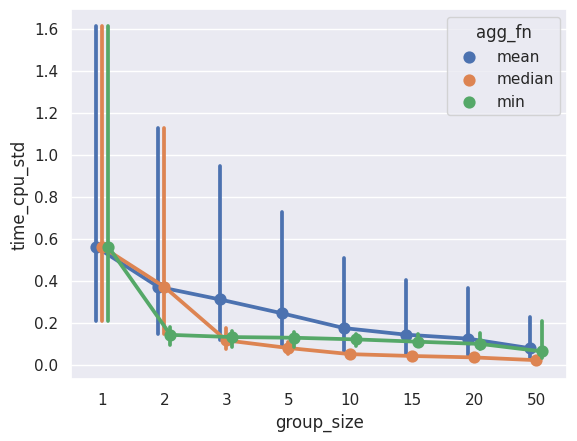

In [242]:
sns.pointplot(
    x="group_size",
    y="time_cpu_std",
    hue="agg_fn",
    estimator="mean",
    errorbar=("pi", 95),
    dodge=0.2,
    data=stats,
)


In [261]:
small_agg_corr = small_agg.groupby(["group_size", "agg_fn"]).apply(
    lambda group: group[metric_cols].corr("kendall").loc["time_cpu"].drop("time_cpu")
)
small_agg_corr.columns.name = None


In [286]:
small_agg_corr_melt = small_agg_corr.reset_index().melt(
    id_vars=["group_size", "agg_fn"], var_name="metric", value_name="correlation"
)


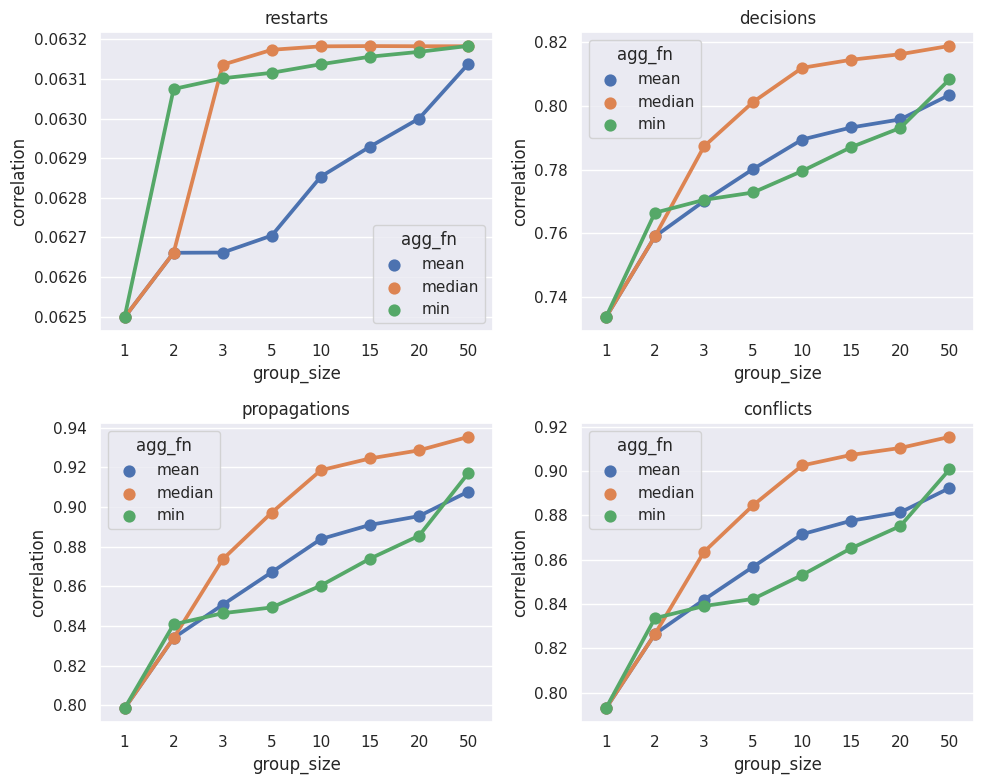

In [308]:
plt.figure(figsize=(10, 8))
for i, metric in enumerate(["restarts", "decisions", "propagations", "conflicts"]):
    plt.subplot(2, 2, i + 1)
    sns.pointplot(
        x="group_size",
        y="correlation",
        hue="agg_fn",
        data=small_agg_corr_melt[small_agg_corr_melt["metric"] == metric],
    )
    plt.title(metric)

plt.tight_layout()


<Axes: xlabel='group_size', ylabel='correlation'>

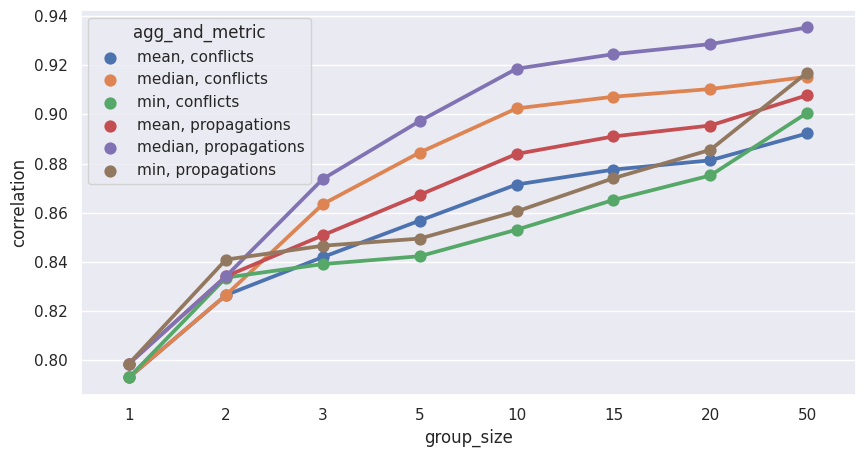

In [321]:
plt.figure(figsize=(10, 5))
small_agg_corr_melt["agg_and_metric"] = small_agg_corr_melt.agg(
    "{0[agg_fn]}, {0[metric]}".format, axis=1
)
sns.pointplot(
    x="group_size",
    y="correlation",
    hue="agg_and_metric",
    data=small_agg_corr_melt[
        small_agg_corr_melt["metric"].isin(["propagations", "conflicts"])
    ],
)
